In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import glob
from zipfile import ZipFile
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import pickle




In [15]:
IMAGE_SIZE= 256

image_size=256
transform = transforms.Compose(
            [transforms.Resize(image_size),
             transforms.ToTensor()
             # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
             ]
        )

In [8]:


# data_path = sorted(glob.glob('/local/scratch/a/rahman89/Datasets/CelebAMask-HQ/CelebAMask-HQ/CelebA-HQ-img/*.jpg')) # This was a bug. It did not sort the images as 0,1,2,...
img_folder = '/local/scratch/a/rahman89/Datasets/CelebAMask-HQ//CelebA-HQ-img/'
label_path = "/local/scratch/a/rahman89/Datasets/CelebAMask-HQ/CelebAMask-HQ-attribute-anno.txt"
sep=" "
rowst=2
colst=2

label_list = open(label_path).readlines()[rowst:]


data_label = []
for i in range(len(label_list)):
    each_row= label_list[i].split(sep)
    data_label.append(each_row)



image_names=[]
for m in range(len(data_label)):
    image_names.append(data_label[m][0])  #image id
    data_label[m] = data_label[m][colst:]  # rest of the labels
    data_label[m] = [int(p) for p in data_label[m]]

attributes = open(label_path).readlines()[1].split(' ')
attributes[-1]= attributes[-1].strip('\n')




In [6]:
import numpy as np
import pandas as pd
labels= np.array(data_label)

data_dict={}
for iter, att in enumerate(attributes):
    data_dict[att] = labels[:,iter]

data_dict['image_id']= image_names
df = pd.DataFrame(data_dict)
df = df.replace([-1], 0)
cur_attrs=['Attractive', 'Bald',  'Eyeglasses',  'Male', 'Mustache', 'Pale_Skin',  'Wearing_Lipstick', 'Young']
all_labels= ['image_id']+ cur_attrs
df = df[all_labels]
df

,image_id,Attractive,Bald,Eyeglasses,Male,Mustache,Pale_Skin,Wearing_Lipstick,Young
0,0.jpg,1,0,0,0,0,0,1,1
1,1.jpg,1,0,0,0,0,0,1,1
2,2.jpg,1,0,0,0,0,0,1,1
3,3.jpg,1,0,0,0,0,0,1,1
4,4.jpg,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
29995,29995.jpg,0,0,1,1,1,0,0,0
29996,29996.jpg,0,0,0,1,0,0,0,1
29997,29997.jpg,0,0,0,0,0,0,0,1
29998,29998.jpg,1,0,0,0,0,0,1,1


In [16]:


m1y1= 500   #1500


def get_images(cur_df):
    images =[]
    new_images=[]
    new_labels={'Male':[], 'Young':[]}
    for iter,id in tqdm(enumerate(cur_df['image_id'])):
        img_path = f'{img_folder}/{id}'
        cur_im = Image.open(img_path)


        m = cur_df['Male'].iloc[[iter]].to_numpy()
        y = cur_df['Young'].iloc[[iter]].to_numpy()

        att_val ={'Male': m, 'Young':y}

        image_tensor = transform(cur_im)
        image= image_tensor.unsqueeze(0)
        new_images.append(image)
        new_labels['Male'].append(m)
        new_labels['Young'].append(y)

    return new_labels, new_images

df_male= df.loc[(df['Male'] == 1)].tail(m1y1)
df_female= df.loc[(df['Male'] == 0)].tail(m1y1)
m1_labels, m1_images= get_images(df_male)
m0_labels, m0_images= get_images(df_female)

name_samples= "10k"

500it [00:03, 157.66it/s]
500it [00:03, 152.09it/s]


In [44]:
from torchvision.utils import save_image

for iter, img in enumerate(m1_images):

    save_image(img[0], f'data/celeba_hq/val/male/img{iter}.png')
    # if iter==20:
    #     break


In [24]:
batch_tensor= torch.cat(m1_images[0:20])
batch_tensor.shape

torch.Size([20, 3, 256, 256])

In [29]:
grid_img = torchvision.utils.make_grid(batch_tensor, nrow=5)
grid_img.shape

torch.Size([3, 1034, 1292])

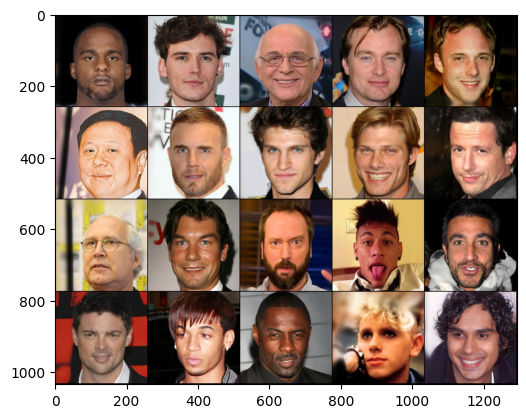

In [30]:
plt.imshow(grid_img.permute(1, 2, 0))

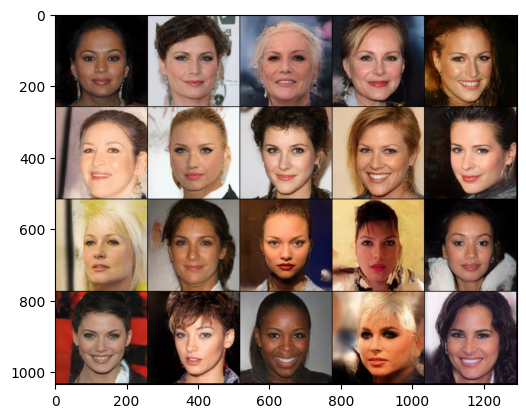

In [43]:
from torchvision.io import read_image
import torchvision.transforms as T
import torchvision.transforms as transforms

org_images=[]
for iter in range(20):
    pic = read_image(f'./runs/male2female/0/img{iter}.png')
    PIL_img = T.ToPILImage()(pic)
    org_images.append(pic.unsqueeze(0))


batch_tensor= torch.cat(org_images)
grid_img = torchvision.utils.make_grid(batch_tensor, nrow=5)
plt.imshow(grid_img.permute(1, 2, 0))
